In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from PIL import Image, ImageOps, ImageFilter
import random

In [2]:
! pip install torchsummary

In [4]:
from torchsummary import summary

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [6]:


def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    running_loss = 0.0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))
    losses = []
    acc = 0.0
    total = 0
    
    for i, (inputs , labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        if train_mode : 
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            acc += (preds == labels).sum().item()
            total += len(labels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss/(i+1))
            losses.append(loss.item())
            
        else:
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                acc += (preds == labels).sum().item()
                total += len(labels)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                progress_bar.set_postfix(loss=running_loss/(i+1))
                losses.append(loss.item())
    print("Epoch finished with loss and accuracy : " ,running_loss/len(data_loader) ,  acc/total)
    
    return losses



def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    optimizer=None,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """


    if optimizer is None : 
        optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_losses_epoch = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        print("Validation : ")
        val_losses_epoch = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        train_losses += train_losses_epoch
        val_losses += val_losses_epoch
    
    return train_losses, val_losses




def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    
    model.eval()
    corrects = 0
    total = 0
    for i , (inputs, labels) in enumerate(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += (preds == labels).sum().item()
        total += len(labels)
    
    return corrects / total



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    
    train_losses_smoothed = np.convolve(train_losses, np.ones(c_window), 'valid') / c_window
    if val_losses is not None : 
        val_losses_smoothed = np.convolve(val_losses, np.ones(c_window), 'valid') / c_window

    if val_losses is not None : 
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses_smoothed, label='Training Loss')
        plt.plot(val_losses_smoothed, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    else : 
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses_smoothed, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    


In [7]:
class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            sigma = random.random() * 1.9 + 0.1
            return img.filter(ImageFilter.GaussianBlur(sigma))
        else:
            return img


class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img


class Transform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                        saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(p=1.0),
            Solarization(p=0.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.transform_prime = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                        saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(p=0.1),
            Solarization(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        y1 = self.transform(x)
        y2 = self.transform_prime(x)
        return y1, y2

transform_ = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])


In [8]:

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True , transform=Transform())
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

# # VALIDATION DATA
# val_set = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True ,transform=transform_)
# val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

100%|██████████| 170498071/170498071 [00:11<00:00, 14329132.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


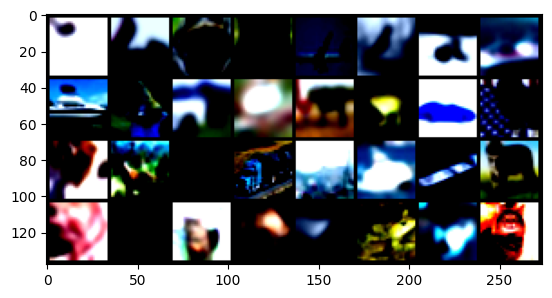

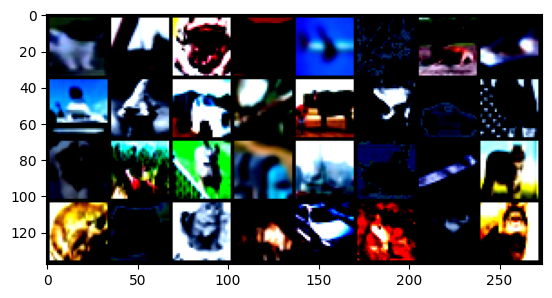

In [9]:
def imshow(img):
    
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, data in enumerate(train_loader, 0):
    imshow(torchvision.utils.make_grid(data[0][0][:32]))
    imshow(torchvision.utils.make_grid(data[0][1][:32]))
    if i == 0:
        break

In [10]:
class BarlowTwins(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torchvision.models.resnet50(weights=None)
        self.backbone.fc = nn.Identity()

        # projector
        sizes = [2048] + list([2048 , 2048 , 2048])
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector = nn.Sequential(*layers)


    def forward(self, x):
        return self.projector(self.backbone(x))

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()



class BT_loss(nn.Module):
    
    def __init__(self , device ,  lamdb: float = 0.01 ) :
        super(BT_loss, self).__init__()
        self.lamdb = lamdb
        self.device = device


    def forward(self,
                y1: torch.Tensor,
                y2: torch.Tensor,
                ) -> torch.Tensor:
        
        y1 = (y1 - y1.mean(0)) / y1.std(0)
        y2 = (y2 - y2.mean(0)) / y2.std(0)
        
        N = y1.size(0)
        D = y1.size(1)
        
        c = torch.mm(y1.T, y2) / N
        c_diff = (c - torch.eye(D, device=self.device)).pow(2)
        c_diff[~torch.eye(D, dtype=bool)] *= self.lamdb
        loss = c_diff.sum()
        
        
        return loss

        

In [11]:
BT_model = BarlowTwins().to(device)
summary(BT_model , (3 , 32 , 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [24]:
def train_BT(BT_model: nn.Module,
             train_loader: torch.utils.data.DataLoader,
             device: torch.device,
             epochs: int = 10,
             lr: float = 0.001,
            ) -> List : 


    losses = []
    BT_model.to(device)

    criterion = BT_loss(lamdb=0.003 , device=device).to(device)
    optimizer = optim.Adam(BT_model.parameters(), lr=lr)
    for epoch in range(epochs) : 
        
        BT_model.train()
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))

        for i , ((x1 , x2) , _) in progress_bar :
            x1 , x2 = x1.to(device) , x2.to(device)
            
            optimizer.zero_grad()
            
            y1 = BT_model(x1)
            y2 = BT_model(x2)
            
            loss = criterion(y1 , y2)
            #losses.append(loss)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix({'loss': running_loss / (i + 1)})
            
        print(f"Epoch {epoch + 1} - Training loss: {running_loss / len(train_loader)}")


    return losses

In [21]:
losses_1_3 = train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=3 , lr = 0.0003)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Training loss: 1984.0139234893177


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Training loss: 1866.765152288943


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Training loss: 1732.0520337163186


In [22]:
losses_4_6 = train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=3 , lr = 0.0001)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Training loss: 1632.4463581941566


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Training loss: 1573.5709396673708


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Training loss: 1506.3738577706474


In [23]:
losses_7_9 = train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=3 , lr = 0.0001)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Training loss: 1390.4132416394293


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Training loss: 1291.2288930464765


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Training loss: 1169.3737475336814


In [24]:
losses_10_12 = train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=3 , lr = 0.0001)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Training loss: 1067.4431859230508


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Training loss: 978.1086058324697


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Training loss: 915.0514021892936


In [25]:
losses_13_15 = train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=3 , lr = 0.0001)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Training loss: 861.6731508216079


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Training loss: 820.624179450833


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Training loss: 787.497384830397


In [26]:
losses_16_18 = train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=3 , lr = 0.00003)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Training loss: 753.921921087771


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Training loss: 737.4958916488958


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Training loss: 728.2096623011997


In [27]:
losses_19_21 = train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=3 , lr = 0.00003)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Training loss: 717.019753280951


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Training loss: 709.221793972716


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Training loss: 700.2423973862005


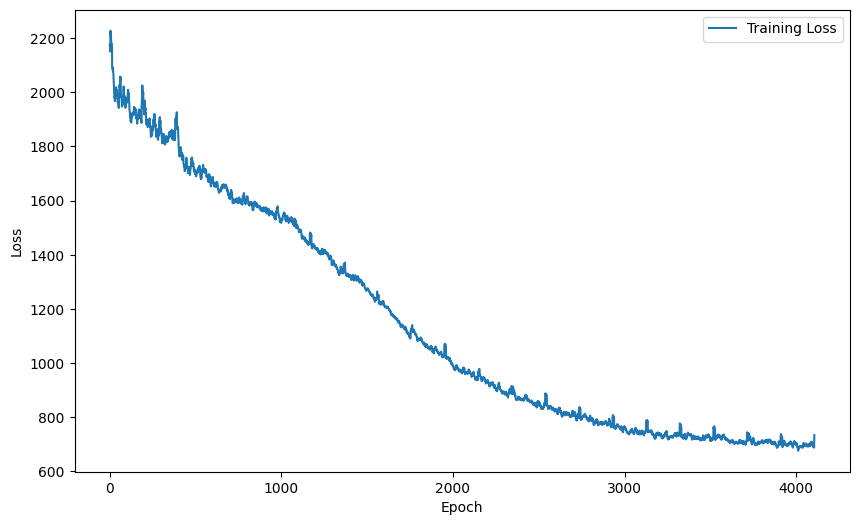

In [32]:
losses = []
for loss in losses_1_3 : 
    losses.append(loss)
for loss in losses_4_6 : 
    losses.append(loss)
for loss in losses_7_9 : 
    losses.append(loss)
for loss in losses_10_12 : 
    losses.append(loss)
for loss in losses_13_15 : 
    losses.append(loss)
for loss in losses_16_18 : 
    losses.append(loss)
for loss in losses_19_21: 
    losses.append(loss)
losses = [loss.cpu().detach().numpy() for loss in losses]
plot_losses(losses , None)

In [31]:
PATH = '/kaggle/input/bt-model-resnet-50-70epoch/BT_model_resnet_50_2.pth'

pretrained_dict = torch.load(PATH , weights_only=True)
BT_model = BarlowTwins().to(device)
BT_model.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [32]:
train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=20 , lr = 0.00003)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Training loss: 306.7319873109156


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Training loss: 299.5444098492058


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Training loss: 300.3511209293288


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4 - Training loss: 296.3693747228506


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5 - Training loss: 294.1098657724809


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6 - Training loss: 293.65938630396005


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7 - Training loss: 290.63203134342115


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8 - Training loss: 289.3952057507573


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9 - Training loss: 288.8228583822445


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10 - Training loss: 289.0981017132195


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11 - Training loss: 287.7527497739208


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12 - Training loss: 284.4592408939284


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13 - Training loss: 282.9618121555873


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14 - Training loss: 280.9908042440609


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15 - Training loss: 282.9354489384865


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16 - Training loss: 281.7467845994599


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17 - Training loss: 278.9322720741739


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18 - Training loss: 278.44072232927596


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19 - Training loss: 278.48698635490575


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20 - Training loss: 275.98956602446884


[]

In [ ]:
train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=40 , lr = 0.0003)

In [ ]:
train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=40 , lr = 0.0003)

In [50]:
train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=10 , lr = 0.00003)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Training loss: 195.39373849362744


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Training loss: 195.70705709652026


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Training loss: 194.56046497578524


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4 - Training loss: 193.64434160505022


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5 - Training loss: 192.57835652876872


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6 - Training loss: 192.89555109763631


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7 - Training loss: 191.66945500276526


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8 - Training loss: 190.88203196622888


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9 - Training loss: 191.68810591405753


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10 - Training loss: 191.95776374972596


[]

In [51]:
torch.save(BT_model.state_dict(), 'BT_model_resnet_50_4.pth')

In [52]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

download_file("BT_model_resnet_50_4.pth" , "BT_model_resnet_50_4")

/kaggle/working/BT_model_resnet_50_4.zip

In [94]:
! ls /kaggle/input/bt-model-resnet-50/BT_model_resnet_50.pth

/kaggle/input/bt-model-resnet-50/BT_model_resnet_50.pth


In [14]:
BT_model = BarlowTwins().to(device)
BT_model.load_state_dict(torch.load(PATH))


/tmp/ipykernel_23/1703129975.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  BT_model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [19]:
class Classifier_with_BT(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torchvision.models.resnet50(weights=None)
        self.backbone.fc = nn.Identity()
        
        sizes = [2048] + list([2048 , 2048 , 2048])
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector = nn.Sequential(*layers)
        
        #classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048, 10),
            nn.Softmax(dim=1)
        )


            

    def forward(self, x):
        return self.classifier(self.projector(self.backbone(x)))

In [20]:
#load the BT_model
# BT_model_pre_trained = BarlowTwins().to(device)
# BT_model_pre_trained.load_state_dict(torch.load(PATH))
# BT_model_dict = BT_model_pre_trained.state_dict()
BT_model_dict = BT_model.state_dict()

classifier = Classifier_with_BT().to(device)
classifier_dict = classifier.state_dict()

#copy the weights from BT_model to classifier
for name, param in BT_model_dict.items():
    if name in classifier_dict:
        classifier_dict[name].data.copy_(param.data)
        
classifier.load_state_dict(classifier_dict)

#freezing the weights of the backbone and the projector

for param in classifier.backbone.parameters():
    param.requires_grad = False
    
for param in classifier.projector.parameters():
    param.requires_grad = False
    
summary(classifier , (3 , 32 , 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [21]:
transform_ = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True , transform=transform_)

val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True ,transform=transform_)

train_loader_c = DataLoader(Subset(val_set, range(0, 8000)), batch_size=128, shuffle=True)
val_loader_c = DataLoader(Subset(val_set, range(8000, 10000)), batch_size=256, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [22]:
optimizer = optim.Adam([
    {'params': classifier.backbone.parameters(), 'lr': 0.000},
    {'params': classifier.projector.parameters(), 'lr': 0.000},
    {'params': classifier.classifier.parameters()}
], lr=0.001)
train_losses, val_losses = train(train_loader_c, val_loader_c, classifier, epochs=20, lr=0.001 , optimizer=optimizer)

Epoch 1
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0867099534897577 0.417625
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0255220234394073 0.4425
Epoch 2
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9917422760100592 0.478375
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.010842278599739 0.452
Epoch 3
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9755869895692855 0.492375
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0048481971025467 0.4565
Epoch 4
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9657690525054932 0.501375
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0005202889442444 0.457
Epoch 5
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9608983615088085 0.50575
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0006130933761597 0.4615
Epoch 6
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9590004758229331 0.506125
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9979362487792969 0.4605
Epoch 7
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.950773311039758 0.51775
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0003963857889175 0.462
Epoch 8
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.947627726055327 0.521125
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9974602460861206 0.458
Epoch 9
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.947048891158331 0.518625
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9974602907896042 0.4615
Epoch 10
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.944311711523268 0.5245
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.998988077044487 0.463
Epoch 11
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9426722223796542 0.52375
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.000110849738121 0.4595
Epoch 12
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9378226238583762 0.531875
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9993440359830856 0.4605
Epoch 13
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9358006148111253 0.528625
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0018758326768875 0.4545
Epoch 14
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9346185184660412 0.530875
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.001201421022415 0.4565
Epoch 15
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9330289382783195 0.5335
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9991418421268463 0.458
Epoch 16
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.932648880141122 0.535625
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.001466751098633 0.457
Epoch 17
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9338235911868868 0.532
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.000772848725319 0.4575
Epoch 18
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.93163181675805 0.534375
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.000148430466652 0.453
Epoch 19
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9314985161735898 0.53675
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.00168876349926 0.4555
Epoch 20
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9274774392445881 0.53875
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0016954839229584 0.455


In [62]:
classifier_2 = Classifier_with_BT().to(device)

In [63]:
optimizer = optim.Adam([
    {'params': classifier_2.backbone.parameters(), 'lr': 0.0001},
    {'params': classifier_2.projector.parameters(), 'lr': 0.0001},
    {'params': classifier_2.classifier.parameters()}
], lr=0.001)

train_losses_2, val_losses_2 = train(train_loader_c, val_loader_c, classifier_2, epochs=20, lr=0.001 , optimizer=optimizer)

Epoch 1
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.2732018326956127 0.163625
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.259043127298355 0.178
Epoch 2
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.2378705077701144 0.204875
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.2390038669109344 0.204
Epoch 3
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.228326286588396 0.21575
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.220588266849518 0.225
Epoch 4
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.191380917079865 0.25475
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1912516355514526 0.257
Epoch 5
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1716630118233815 0.28025
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1855779886245728 0.2635
Epoch 6
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.164170087329925 0.2885
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1970913112163544 0.2585
Epoch 7
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1453595729101274 0.309625
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1802939772605896 0.273
Epoch 8
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1381263505844843 0.317875
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.173985540866852 0.2805
Epoch 9
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.123111649165078 0.33325
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1691580712795258 0.2885
Epoch 10
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.108067966642834 0.34675
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1552151441574097 0.299
Epoch 11
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.095286776149084 0.361875
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1490369141101837 0.307
Epoch 12
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.095104289433313 0.362875
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.140476793050766 0.3175
Epoch 13
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0878713130950928 0.370625
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.148087292909622 0.307
Epoch 14
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0878957528916615 0.36675
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.167840003967285 0.2855
Epoch 15
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0929315695686945 0.364375
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1458964943885803 0.309
Epoch 16
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0867332541753374 0.37175
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1299546658992767 0.329
Epoch 17
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.082249402999878 0.3745
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.137890011072159 0.316
Epoch 18
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0778558613762024 0.380375
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1450663208961487 0.3145
Epoch 19
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0628876610407754 0.396125
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1488049924373627 0.3115
Epoch 20
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.0771408137821017 0.3805
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1340127885341644 0.3245
